In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Load the data

         date  capacity    turnover  change  transaction    open    high  \
0  2024-01-02   6283610   848793104   -0.55        10013  135.60  135.95   
1  2024-01-03  14783894  1963126583   -2.35        25258  133.70  133.90   
2  2024-01-04   4838660   641202865   -0.05         7094  132.55  132.75   
3  2024-01-05   4566320   604475455   -0.35        12744  132.55  132.95   
4  2024-01-08   9657556  1285524342    0.60         9876  133.00  133.60   

      low   close  
0  134.65  134.90  
1  132.30  132.55  
2  132.30  132.50  
3  132.10  132.15  
4  132.75  132.75  


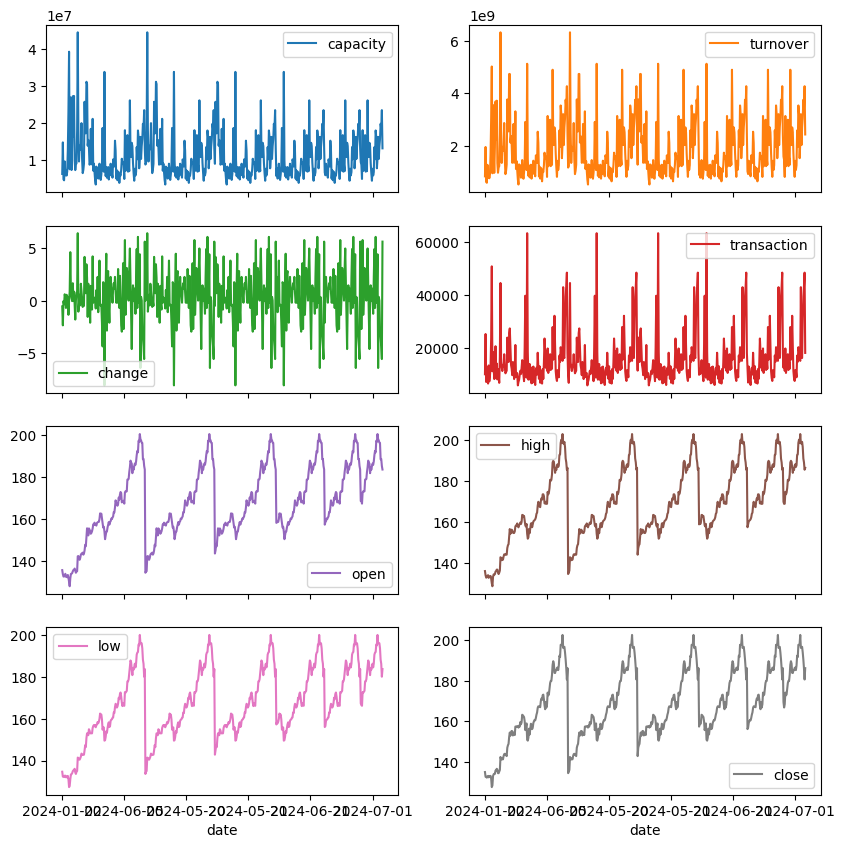

In [ ]:
data = pd.read_csv('/content/0050.csv')

# Visualize the data
print(data.head())
data.plot(x='date', y=['capacity', 'turnover', 'change', 'transaction', 'open', 'high', 'low', 'close'], subplots=True, layout=(4, 2), figsize=(10, 10))
plt.show()

# Preprocess the data

## Datetime formatting

In [ ]:
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

## Select features and target

In [ ]:
features = ['capacity', 'turnover', 'change', 'transaction', 'open', 'high', 'low']
target = 'close'

## Normalize the data

In [ ]:
scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])
target_scaler = MinMaxScaler()
data[target] = target_scaler.fit_transform(data[[target]])

# Convert to numpy arrays
X = data[features].values
y = data[target].values

## Create sequences

In [ ]:
def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

seq_length = 10
X_seq, y_seq = create_sequences(X, y, seq_length)

## Split into train and test sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

## Convert to PyTorch tensors

In [ ]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Define the RNN model

In [ ]:
class StockPriceRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(StockPriceRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

# Hyperparameters

In [ ]:
input_size = len(features)
hidden_size = 50
output_size = 1
num_layers = 2
num_epochs = 100
learning_rate = 0.001

# Initialize the model, loss function, and optimizer

In [ ]:
model = StockPriceRNN(input_size, hidden_size, output_size, num_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model

In [ ]:
train_losses = []
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 0.0593
Epoch [20/100], Loss: 0.0266
Epoch [30/100], Loss: 0.0194
Epoch [40/100], Loss: 0.0125
Epoch [50/100], Loss: 0.0060
Epoch [60/100], Loss: 0.0056
Epoch [70/100], Loss: 0.0044
Epoch [80/100], Loss: 0.0041
Epoch [90/100], Loss: 0.0037
Epoch [100/100], Loss: 0.0034


# Plot training loss

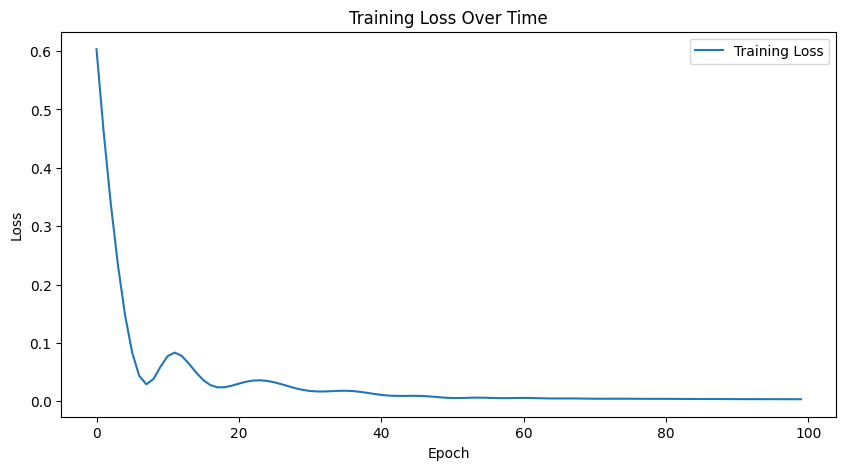

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.show()

# Evaluate the model

In [ ]:
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    print(f'Test Loss: {test_loss.item():.4f}')

# Inverse transform the predictions and actual values
y_test_inv = target_scaler.inverse_transform(y_test.numpy())
test_outputs_inv = target_scaler.inverse_transform(test_outputs.numpy())

Test Loss: 0.0060


# Visualize the predictions

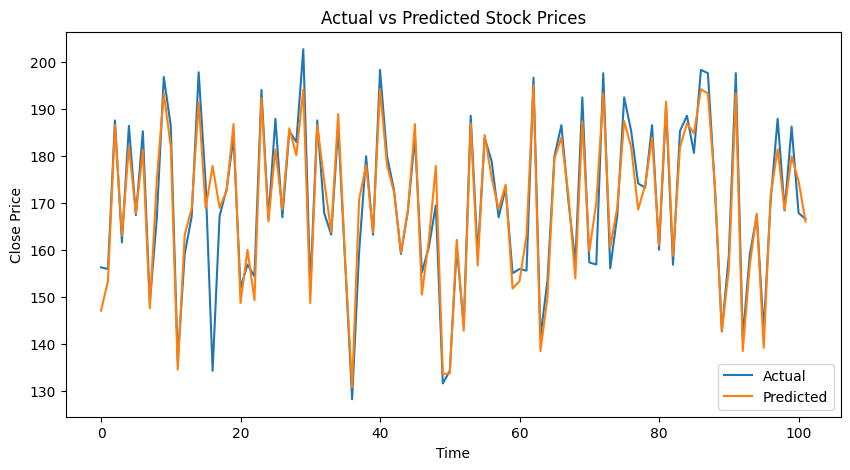

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(y_test_inv, label='Actual')
plt.plot(test_outputs_inv, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Stock Prices')
plt.legend()
plt.show()

# Calculate accuracy (e.g., Mean Absolute Percentage Error)

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_test_inv, test_outputs_inv)
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

Mean Absolute Percentage Error (MAPE): 103.76%


# If you want to save the model

In [ ]:
torch.save(model.state_dict(), 'stock_price_rnn.pth')

# Full code

         date  capacity    turnover  change  transaction    open    high  \
0  2024-01-02   6283610   848793104   -0.55        10013  135.60  135.95   
1  2024-01-03  14783894  1963126583   -2.35        25258  133.70  133.90   
2  2024-01-04   4838660   641202865   -0.05         7094  132.55  132.75   
3  2024-01-05   4566320   604475455   -0.35        12744  132.55  132.95   
4  2024-01-08   9657556  1285524342    0.60         9876  133.00  133.60   

      low   close  
0  134.65  134.90  
1  132.30  132.55  
2  132.30  132.50  
3  132.10  132.15  
4  132.75  132.75  
Epoch [10/100], Loss: 0.1166
Epoch [20/100], Loss: 0.0461
Epoch [30/100], Loss: 0.0239
Epoch [40/100], Loss: 0.0164
Epoch [50/100], Loss: 0.0106
Epoch [60/100], Loss: 0.0069
Epoch [70/100], Loss: 0.0057
Epoch [80/100], Loss: 0.0052
Epoch [90/100], Loss: 0.0046
Epoch [100/100], Loss: 0.0043


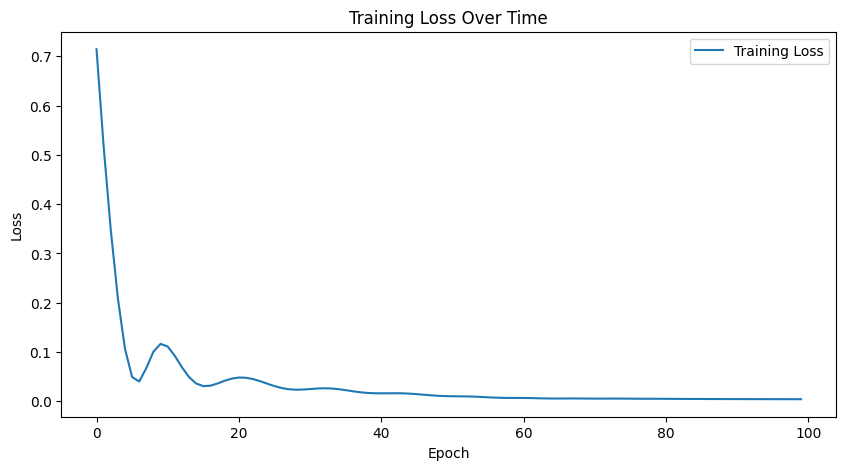

Test Loss: 0.0068


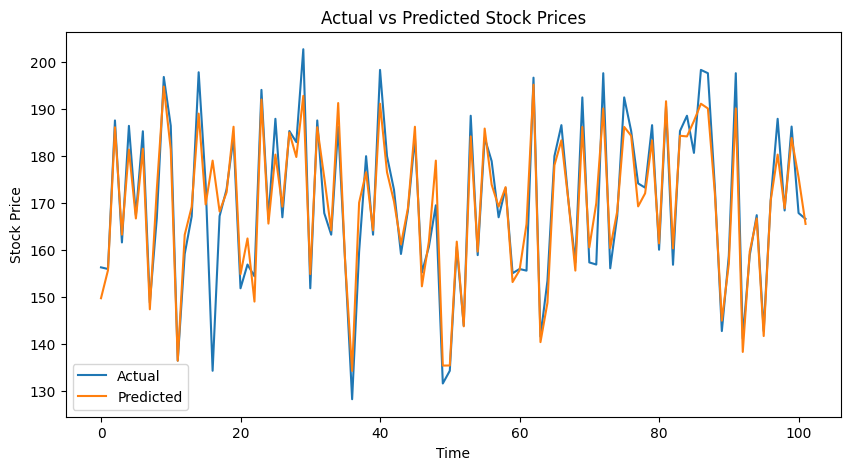

Mean Absolute Percentage Error (MAPE): 2.25%


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Load the data
data = pd.read_csv('/content/0050.csv')

# Visualize the data
print(data.head())
data.plot(x='date', y=['capacity', 'turnover', 'change', 'transaction', 'open', 'high', 'low', 'close'], subplots=True, layout=(4, 2), figsize=(10, 10))
plt.show()

# Preprocess the data
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

# Select features and target
features = ['capacity', 'turnover', 'change', 'transaction', 'open', 'high', 'low']
target = 'close'

# Normalize the data
scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])
target_scaler = MinMaxScaler()
data[target] = target_scaler.fit_transform(data[[target]])

# Convert to numpy arrays
X = data[features].values
y = data[target].values

# Create sequences
def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

seq_length = 10
X_seq, y_seq = create_sequences(X, y, seq_length)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)


# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Define the RNN model
class StockPriceRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(StockPriceRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

# Hyperparameters
input_size = len(features)
hidden_size = 50
output_size = 1
num_layers = 2
num_epochs = 100
learning_rate = 0.001

# Initialize the model, loss function, and optimizer
model = StockPriceRNN(input_size, hidden_size, output_size, num_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
train_losses = []
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.show()

# Evaluate the model
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    print(f'Test Loss: {test_loss.item():.4f}')

# Inverse transform the predictions and actual values
y_test_inv = target_scaler.inverse_transform(y_test.numpy())
test_outputs_inv = target_scaler.inverse_transform(test_outputs.numpy())

# Visualize the predictions
plt.figure(figsize=(10, 5))
plt.plot(y_test_inv, label='Actual')
plt.plot(test_outputs_inv, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Actual vs Predicted Stock Prices')
plt.legend()
plt.show()

# Calculate accuracy (e.g., Mean Absolute Percentage Error)
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_test_inv, test_outputs_inv)
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

# If you want to save the model
torch.save(model.state_dict(), 'stock_price_rnn.pth')